In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import matplotlib.pyplot as plt
import PIL

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

using device: cuda


In [2]:
import glob
import random
from PIL import Image
from pathlib import Path
import numpy as np

# prepare data
class FaceDataset(Dataset):
    def __init__(self, folder, trns=None):
        super().__init__()
        self.folder = folder
        self.trns = trns
        self.items = glob.glob(f"{self.folder}/*/*")

    def __len__(self):
        return len(self.items)

    def choose(self, items):
        ix = random.randint(0, len(items)-1)
        return items[ix]
    
    def __getitem__(self, ix):
        imga_path = self.items[ix]
        person = Path(imga_path).parent.name
        same_person = random.randint(0,1)
        if same_person:
            imgb_path = self.choose(glob.glob(f"{self.folder}/{person}/*"))
        else:
            while True:
                imgb_path = self.choose(self.items)
                if Path(imgb_path).parent.name != person:
                    break
        
        imga = Image.open(imga_path)
        imgb = Image.open(imgb_path)
        if self.trns:
            imga = self.trns(imga)
            imgb = self.trns(imgb)

        return imga, imgb, 1-same_person

train_trns = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomAffine(5, (0.01, 0.2), scale=(0.9, 1.1)),
    T.Resize((100, 100)),
    T.ToTensor(),
    T.Normalize((0.5), (0.5))
])
val_trns = T.Compose([
    T.Resize((100, 100)),
    T.ToTensor(),
    T.Normalize((0.5), (0.5))
])

train_ds = FaceDataset(r"E:\datasets\faces\training", trns=train_trns)
val_ds = FaceDataset(r"E:\datasets\faces\testing", trns=val_trns)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

print(f"train dataset: {len(train_ds)}, test dataset: {len(val_ds)}")


train dataset: 370, test dataset: 30


torch.Size([1, 100, 100])


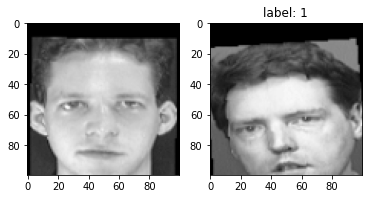

In [3]:
from torchvision.utils import make_grid
imga, imgb, label = train_ds[0]

print(imga.shape)

plt.subplot(121)
plt.imshow(imga.permute(1,2,0), cmap="gray")
plt.subplot(122)
plt.imshow(imgb.permute(1,2,0), cmap="gray")
plt.title(f"label: {label}")

plt.show()

In [4]:
# prepare the model
import torch.nn.functional as F

def convBlock(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            convBlock(1, 4),
            convBlock(4, 8),
            convBlock(8, 16),
            convBlock(16, 32),
            convBlock(32, 64),
            nn.Conv2d(64, 64, kernel_size=10, stride=10, padding=0),
            nn.BatchNorm2d(64),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(64*10*10, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 32)
        )


    def forward(self, imgas, imgbs):
        fmapas = self.features(imgas)
        fmapbs = self.features(imgbs)
        return fmapas, fmapbs


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2):
        super().__init__()
        self.margin = margin
    
    def forward(self, features_a, features_b, label):
        distance = F.pairwise_distance(features_a, features_b)
        loss_same = (1-label)*(torch.pow(distance, 2))
        loss_diff = label * (torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))
        loss_contrastiv = torch.mean(loss_same + loss_diff)
        acc = ((distance > 0.6) == label).float().mean()
        return loss_contrastiv, acc

model = SiameseNetwork().to(device)
lossfn = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, threshold=1e-6, min_lr=1e-6,
    threshold_mode="abs", verbose=True, factor=0.25)

In [5]:
# training utility

def train_batch(model, imgas, imgbs, labels, optimizer, lossfn):
    model.train()
    imgas, imgbs, labels = imgas.to(device), imgbs.to(device), labels.to(device)
    features_a, features_b = model(imgas, imgbs)
    loss, acc = lossfn(features_a, features_b, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.cpu().item(), acc.cpu().item()

@torch.no_grad()
def val_batch(model, imgas, imgbs, labels, lossfn):
    model.eval()
    imgas, imgbs, labels = imgas.to(device), imgbs.to(device), labels.to(device)
    features_a, features_b = model(imgas, imgbs)
    loss, acc = lossfn(features_a, features_b, labels)
    return loss.cpu().item(), acc.cpu().item()


In [6]:
import time

for epoch in range(200):
    start = time.time()
    train_losses = []
    train_acces = []
    val_losses = []
    val_acces = []
    for imgas, imgbs, labels in train_dl:
        loss, acc = train_batch(model, imgas, imgbs, labels, optimizer, lossfn)
        train_losses.append(loss)
        train_acces.append(acc)

    for imgas, imgbs, labels in val_dl:
        loss, acc = val_batch(model, imgas, imgbs, labels, lossfn)
        val_losses.append(loss)
        val_acces.append(acc)

    train_loss = np.mean(train_losses)
    train_acc = np.mean(train_acces)
    val_loss = np.mean(val_losses)
    val_acc = np.mean(val_acces)
    scheduler.step(train_loss)
    end = time.time()
    print(f"epoch {epoch} consumes {end - start}s, train loss: {train_loss:.2f}, train acc: {train_acc:.2f}, \
        test loss: {val_loss:.2f}, test acc: {val_acc:.2f}")

torch.save(model, "siames.pth")


epoch 0 consumes 3.591249704360962s, train loss: 585.29, train acc: 0.50,         test loss: 0.72, test acc: 0.83
epoch 1 consumes 0.6732444763183594s, train loss: 42.27, train acc: 0.49,         test loss: 19.85, test acc: 0.67
epoch 2 consumes 0.6756479740142822s, train loss: 18.96, train acc: 0.48,         test loss: 27.40, test acc: 0.64
epoch 3 consumes 0.6675934791564941s, train loss: 10.86, train acc: 0.47,         test loss: 9.26, test acc: 0.58
epoch 4 consumes 0.6694622039794922s, train loss: 9.32, train acc: 0.49,         test loss: 5.13, test acc: 0.63
epoch 5 consumes 0.6857452392578125s, train loss: 8.57, train acc: 0.47,         test loss: 8.88, test acc: 0.44
epoch 6 consumes 0.6839554309844971s, train loss: 8.15, train acc: 0.46,         test loss: 4.24, test acc: 0.50
epoch 7 consumes 0.6777727603912354s, train loss: 6.83, train acc: 0.54,         test loss: 2.07, test acc: 0.66
epoch 8 consumes 0.6841690540313721s, train loss: 5.97, train acc: 0.49,         test loss